# New Section

In [33]:
# import image file from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import numpy as np
import pandas as pd
import gc, os

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from multiprocessing import cpu_count
from tqdm import tqdm
from matplotlib import pyplot as plt

In [35]:
# const

test_original_data  = '/content/drive/My Drive/KHDLUD/src/input/test.csv'
train_original_data = '/content/drive/My Drive/KHDLUD/src/input/train.csv'
sample_submission_file = '/content/drive/My Drive/KHDLUD/src/input/sample_submission.csv'
SUBMIT_FILE_PATH = f'/content/drive/My Drive/KHDLUD/src/output/2nd-place-solution.csv.gz'
OUT_PUT = '/content/drive/My Drive/KHDLUD/src/output/'

In [36]:
# config

drop_vars = [7,
            10,
            17,
            27,
            29,
            30,
            38,
            41,
            46,
            96,
            100,
            103,
            126,
            158,
            185]

var_len = 200 - len(drop_vars)
NFOLD = 10
NROUND = 1600

In [37]:
%%time

te_ = pd.read_csv(test_original_data).drop(['ID_code'], axis=1).values

unique_samples = []
unique_count = np.zeros_like(te_)
for feature in tqdm(range(te_.shape[1])):
    _, index_, count_ = np.unique(te_[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1


100%|██████████| 200/200 [00:06<00:00, 31.00it/s]

CPU times: user 15.3 s, sys: 327 ms, total: 15.6 s
Wall time: 16.2 s


In [38]:
%%time

real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

CPU times: user 90.6 ms, sys: 0 ns, total: 90.6 ms
Wall time: 91.6 ms


In [39]:
params = {
    'bagging_freq': 5,
    'bagging_fraction': 1.0,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 1.0,
    'learning_rate': 0.005,
    'max_depth': -1,
    'metric':'binary_logloss',
    'min_data_in_leaf': 30,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 64,
    'num_threads': cpu_count(),
    'tree_learner': 'serial',
    'objective': 'binary',
    'verbosity': -1
    }
SEED = np.random.randint(99999)
np.random.seed(SEED)

0


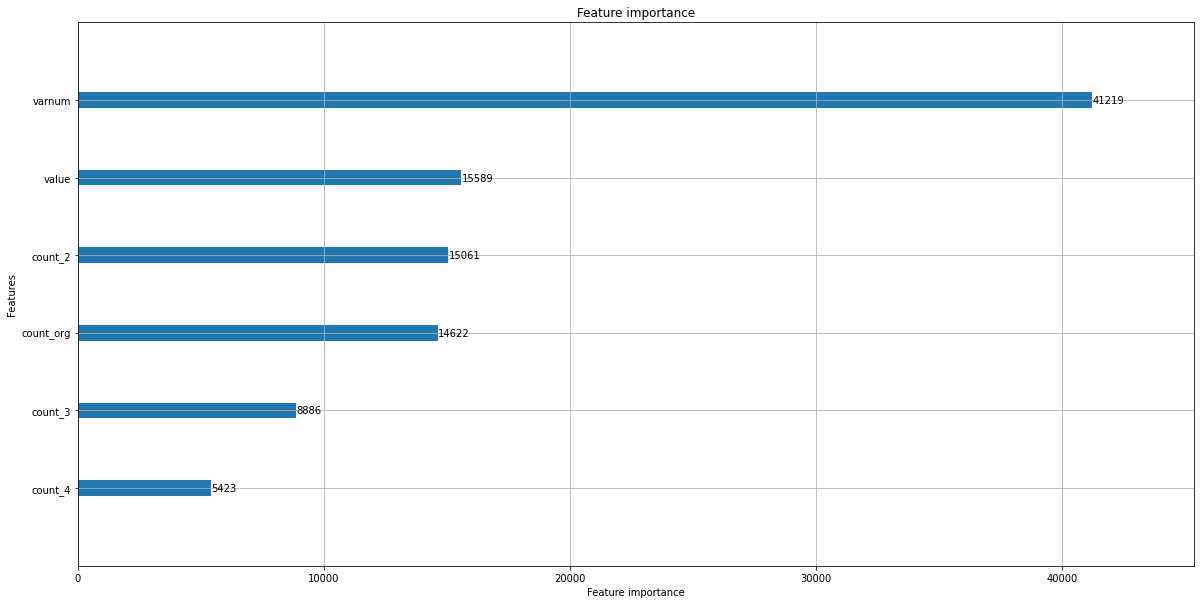

1


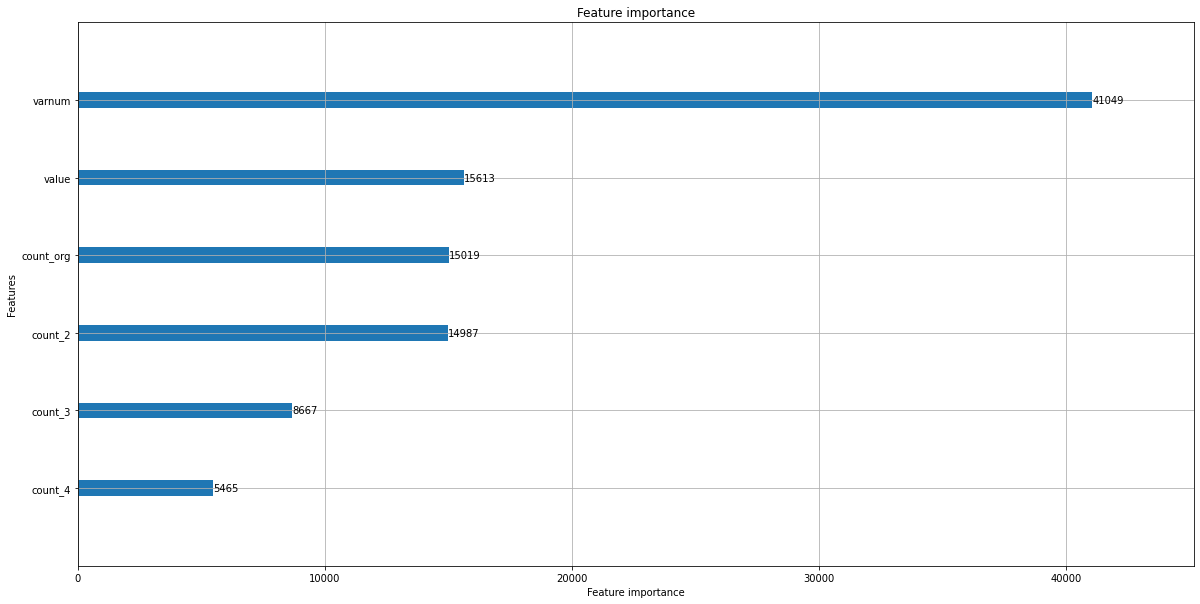

2


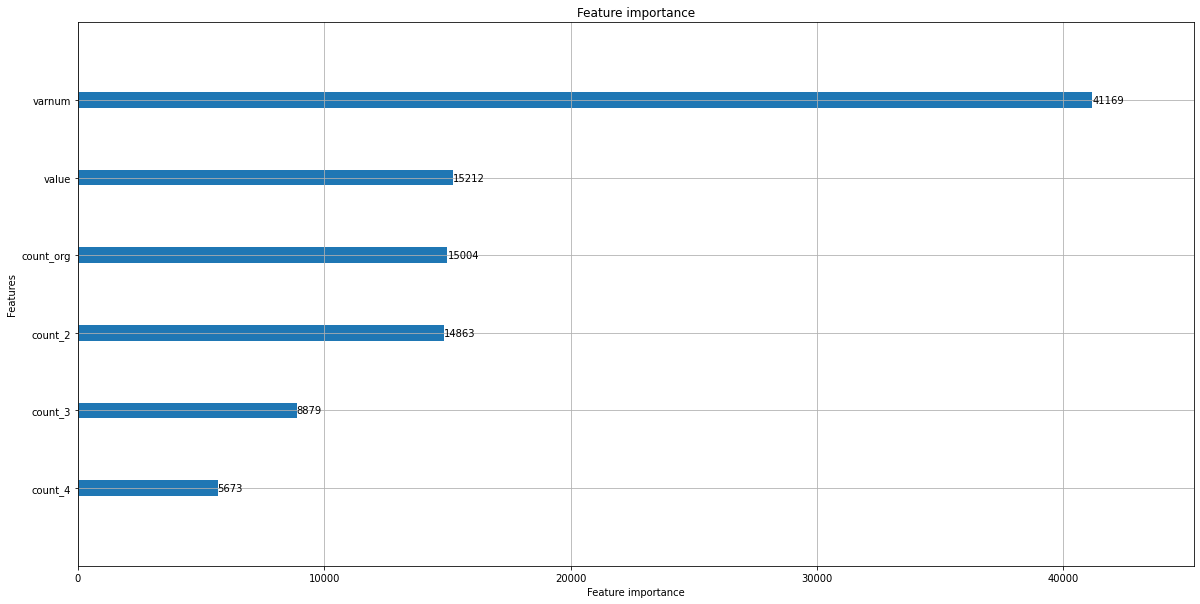

3


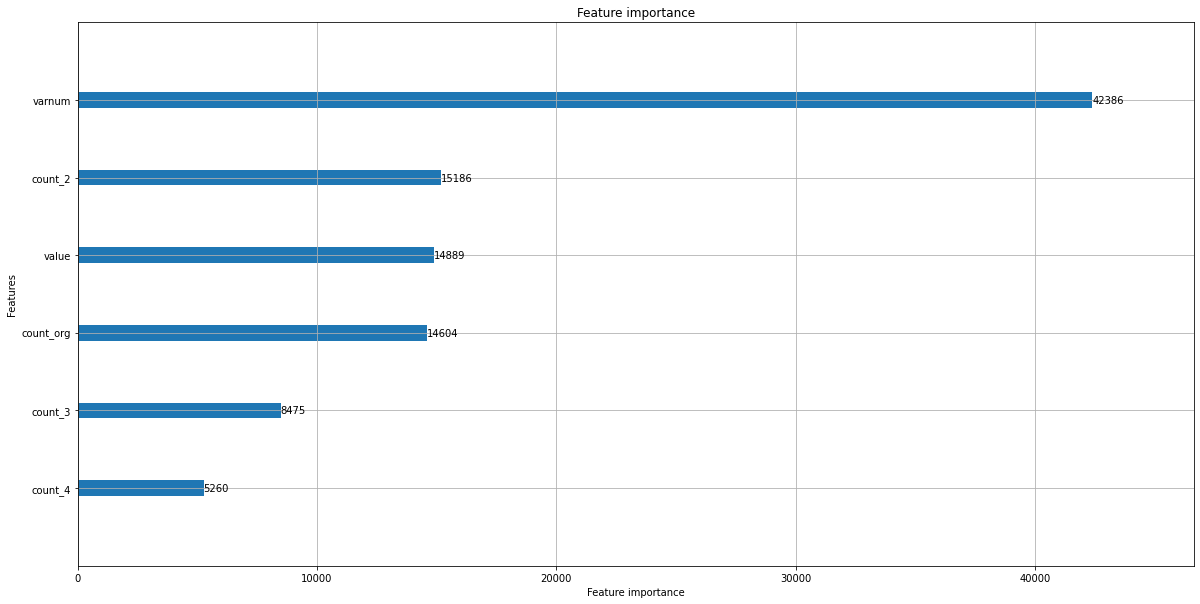

4


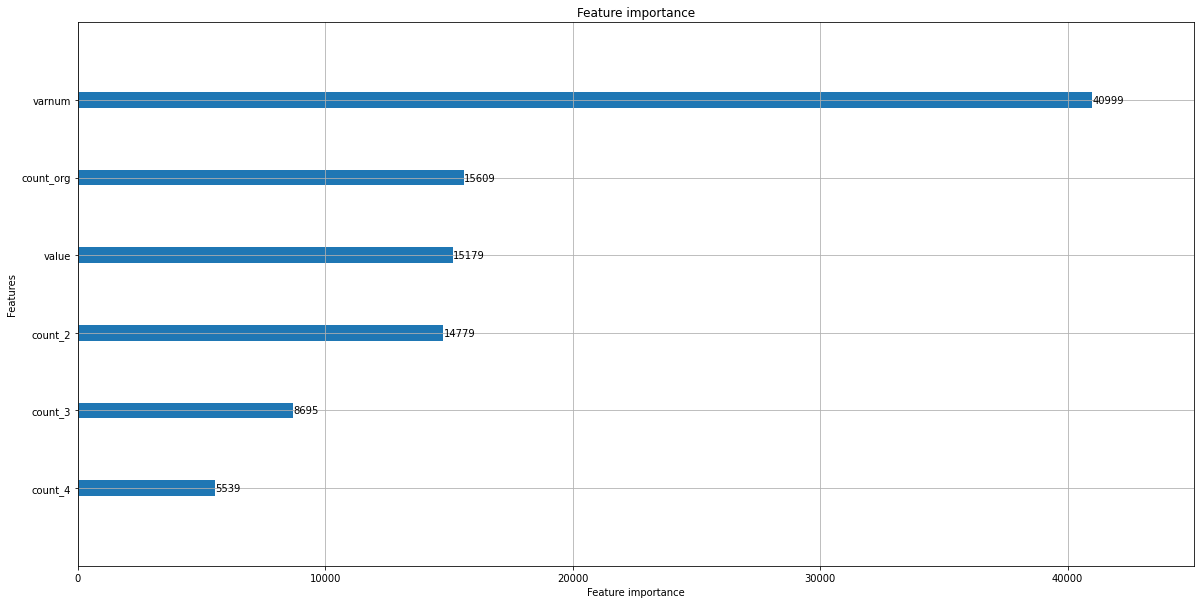

5


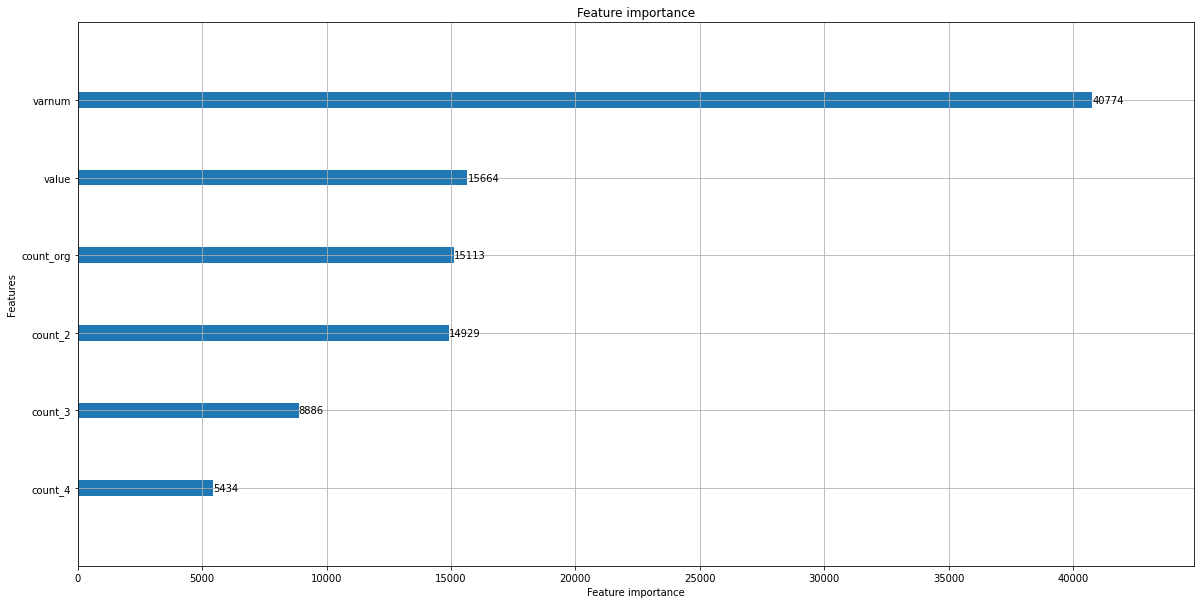

6


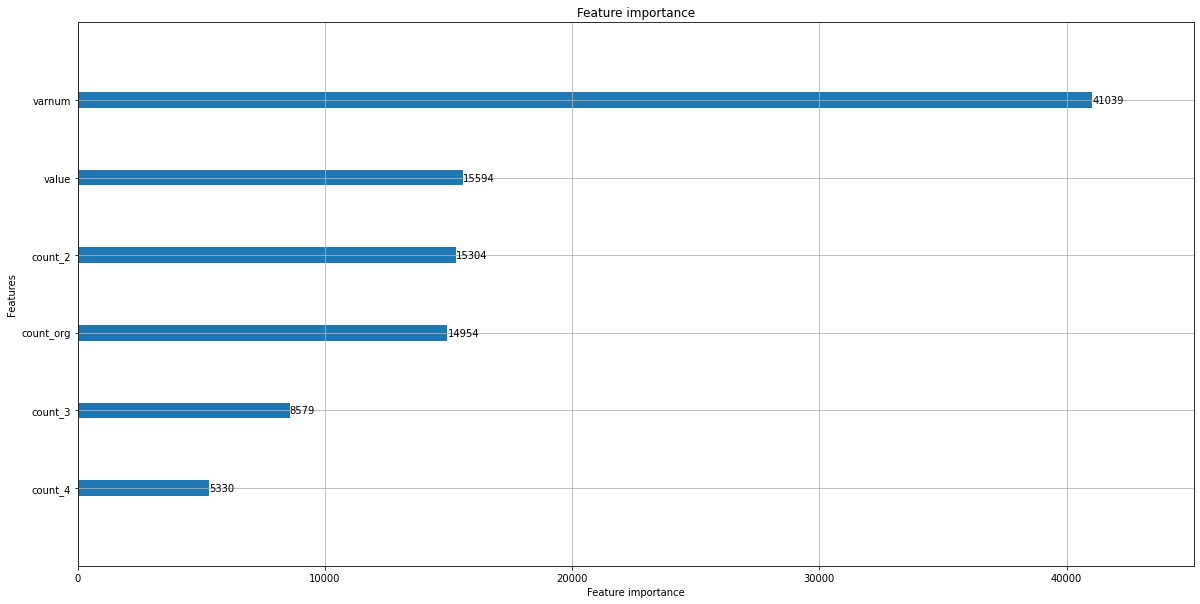

7


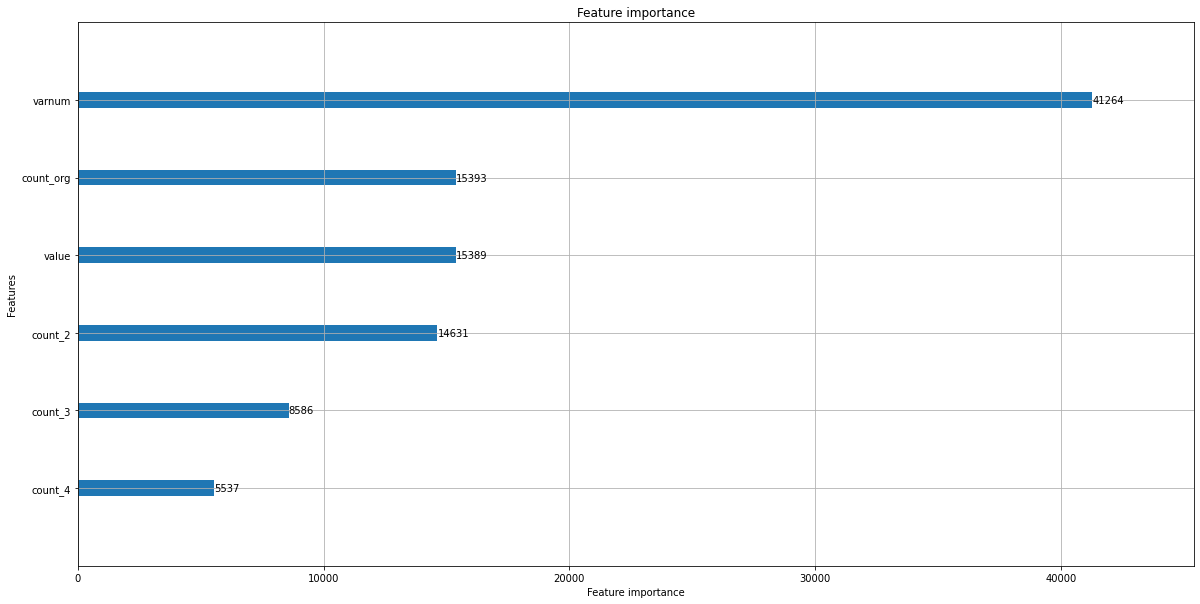

8


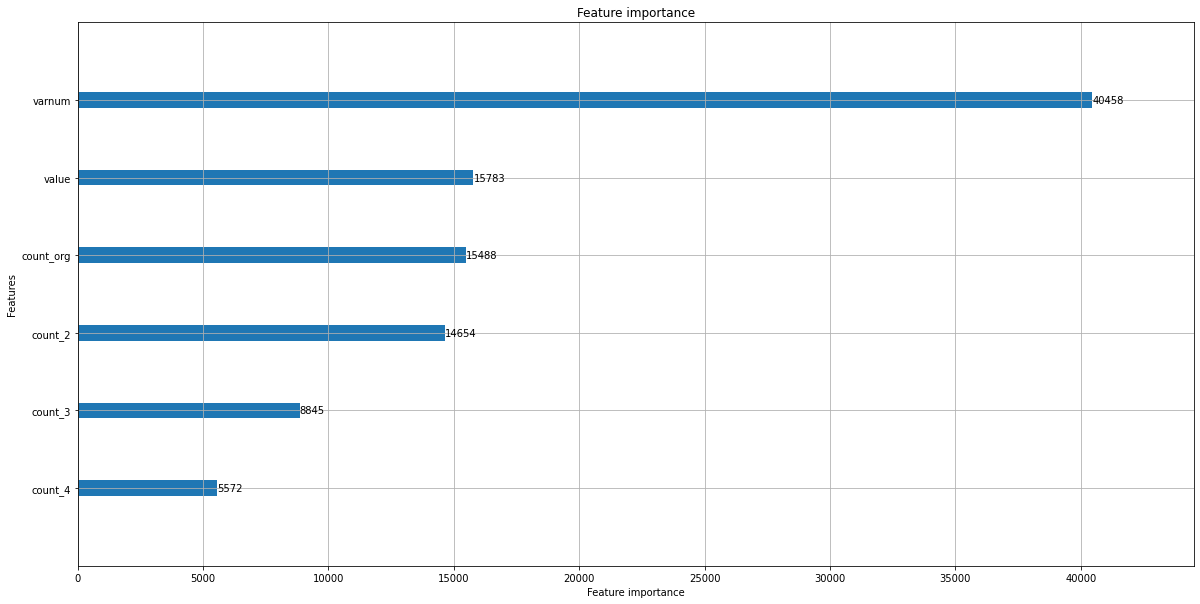

9


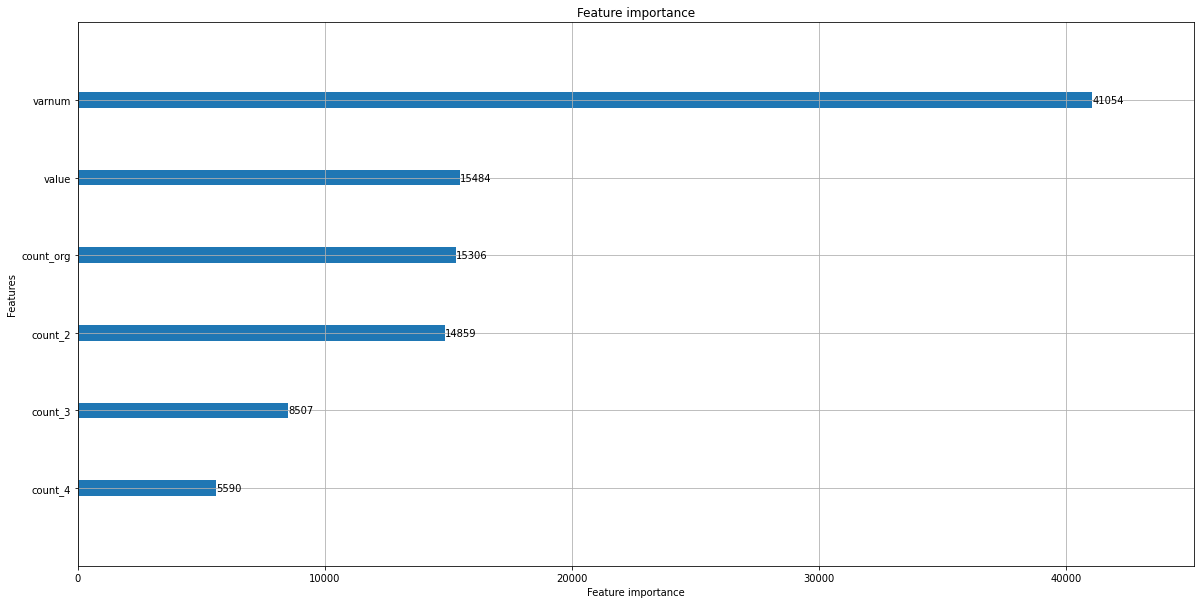

In [43]:
models = []
for i in range(10):
  print(i)
  file =OUT_PUT+'model'+ str(i)+'.txt'
  tree_img =OUT_PUT+'tree_model'+ str(i)+'.svg'
  model = lgb.Booster(model_file=file)
  tree = lgb.create_tree_digraph(model)
  with open(tree_img, 'w') as f:
    f.write(tree._repr_svg_())

  fig, ax = plt.subplots(figsize=(20, 10))
  lgb.plot_importance(model,ax=ax)
  feat_importance_img =OUT_PUT+'feat_importance_model'+ str(i)+'.png'
  plt.savefig(feat_importance_img)
  plt.show()

  models.append(model)


In [ ]:
%%time

train = pd.read_csv(train_original_data)
test  = pd.read_csv(test_original_data).drop(synthetic_samples_indexes)

X_train = train.iloc[:, 2:].values
y_train = train.target.values

X_test = test.iloc[:, 1:].values

X = np.concatenate([X_train, X_test], axis=0)
del X_train, X_test; gc.collect()

reverse_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 15, 16, 18, 19, 22, 24, 25, 26,
                27, 29, 32, 35, 37, 40, 41, 47, 48, 49, 51, 52, 53, 55, 60, 61,
                62, 65, 66, 67, 69, 70, 71, 74, 78, 79, 82, 84, 89, 90, 91, 94,
                95, 96, 97, 99, 103, 105, 106, 110, 111, 112, 118, 119, 125, 128,
                130, 133, 134, 135, 137, 138, 140, 144, 145, 147, 151, 155, 157,
                159, 161, 162, 163, 164, 167, 168, 170, 171, 173, 175, 176, 179,
                180, 181, 184, 185, 187, 189, 190, 191, 195, 196, 199,
                
                ]

for j in reverse_list:
    X[:, j] *= -1

CPU times: user 11.2 s, sys: 534 ms, total: 11.8 s
Wall time: 12 s


In [ ]:
%%time

# drop
X = np.delete(X, drop_vars, 1)

# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# count encoding
X_cnt = np.zeros((len(X), var_len * 4))

for j in tqdm(range(var_len)):
    for i in range(1, 4):
        x = np.round(X[:, j], i+1)
        dic = pd.value_counts(x).to_dict()
        X_cnt[:, i+j*4] = pd.Series(x).map(dic)
    x = X[:, j]
    dic = pd.value_counts(x).to_dict()
    X_cnt[:, j*4] = pd.Series(x).map(dic)

# raw + count feature
X_raw = X.copy() # rename for readable
del X; gc.collect()

X = np.zeros((len(X_raw), var_len * 5))
for j in tqdm(range(var_len)):
    X[:, 5*j+1:5*j+5] = X_cnt[:, 4*j:4*j+4]
    X[:, 5*j] = X_raw[:, j]

# treat each var as same
X_train_concat = np.concatenate([
    np.concatenate([
        X[:200000, 5*cnum:5*cnum+5], 
        np.ones((len(y_train), 1)).astype("int")*cnum
    ], axis=1) for cnum in range(var_len)], axis=0)
y_train_concat = np.concatenate([y_train for cnum in range(var_len)], axis=0)

100%|██████████| 185/185 [00:04<00:00, 40.05it/s]


CPU times: user 1min 24s, sys: 3.61 s, total: 1min 27s
Wall time: 1min 26s


In [ ]:
%%time

train_group = np.arange(len(X_train_concat))%200000

id_y = pd.DataFrame(zip(train_group, y_train_concat), 
                    columns=['id', 'y'])

id_y_uq = id_y.drop_duplicates('id').reset_index(drop=True)

def stratified(nfold=5):
    
    id_y_uq0 = id_y_uq[id_y_uq.y==0].sample(frac=1)
    id_y_uq1 = id_y_uq[id_y_uq.y==1].sample(frac=1)
    
    id_y_uq0['g'] = [i%nfold for i in range(len(id_y_uq0))]
    id_y_uq1['g'] = [i%nfold for i in range(len(id_y_uq1))]
    id_y_uq_ = pd.concat([id_y_uq0, id_y_uq1])
    
    id_y_ = pd.merge(id_y[['id']], id_y_uq_, how='left', on='id')
    
    train_idx_list = []
    valid_idx_list = []
    for i in range(nfold):
        train_idx = id_y_[id_y_.g!=i].index
        train_idx_list.append(train_idx)
        valid_idx = id_y_[id_y_.g==i].index
        valid_idx_list.append(valid_idx)
    
    return train_idx_list, valid_idx_list

train_idx_list, valid_idx_list = stratified(NFOLD)

CPU times: user 44.6 s, sys: 3.9 s, total: 48.5 s
Wall time: 47 s


In [ ]:
%%time

models = []
oof = np.zeros(len(id_y))
p_test_all = np.zeros((100000, var_len, NFOLD))
id_y['var'] = np.concatenate([np.ones(200000)*i for i in range(var_len)])

print(NFOLD)
skip =[]
for i in  tqdm(range(NFOLD)):
    if i in skip:
      continue
    print(f'building {i}...')
    
    train_idx = train_idx_list[i]
    valid_idx = valid_idx_list[i]
    
    # train
    X_train_cv = X_train_concat[train_idx]
    y_train_cv = y_train_concat[train_idx]
    
    # valid
    X_valid = X_train_concat[valid_idx]
    
    # test
    X_test = np.concatenate([
        np.concatenate([
            X[200000:, 5*cnum:5*cnum+5], 
            np.ones((100000, 1)).astype("int")*cnum
        ], axis=1) for cnum in range(var_len)], axis=0
    )
    print('gen Dataset')
    dtrain = lgb.Dataset(
        X_train_cv, y_train_cv, 
        feature_name=['value', 'count_org', 'count_2', 'count_3', 'count_4', 'varnum'], 
        categorical_feature=['varnum'], free_raw_data=False
    )

In [ ]:
%%time

models = []
oof = np.zeros(len(id_y))
p_test_all = np.zeros((100000, var_len, NFOLD))
id_y['var'] = np.concatenate([np.ones(200000)*i for i in range(var_len)])

print(NFOLD)
skip =[]
for i in  tqdm(range(NFOLD)):
    if i in skip:
      continue
    print(f'building {i}...')
    
    train_idx = train_idx_list[i]
    valid_idx = valid_idx_list[i]
    
    # train
    X_train_cv = X_train_concat[train_idx]
    y_train_cv = y_train_concat[train_idx]
    
    # valid
    X_valid = X_train_concat[valid_idx]
    
    # test
    X_test = np.concatenate([
        np.concatenate([
            X[200000:, 5*cnum:5*cnum+5], 
            np.ones((100000, 1)).astype("int")*cnum
        ], axis=1) for cnum in range(var_len)], axis=0
    )
    print('gen Dataset')
    dtrain = lgb.Dataset(
        X_train_cv, y_train_cv, 
        feature_name=['value', 'count_org', 'count_2', 'count_3', 'count_4', 'varnum'], 
        categorical_feature=['varnum'], free_raw_data=False
    )
    print('Trainning....')
    model = lgb.train(params, train_set=dtrain, num_boost_round=NROUND, verbose_eval=100)
    l = valid_idx.shape[0]

    model.save_model(OUT_PUT+'model'+ str(i)+'.txt', num_iteration=model.best_iteration)
    
    print('Predicting....')
    p_valid = model.predict(X_valid)
    p_test  = model.predict(X_test)
    for j in tqdm(range(var_len)):
        oof[valid_idx] = p_valid
        p_test_all[:, j, i] = p_test[j*100000:(j+1)*100000]
    '''
        my_model.booster_.save_model('mode.txt')
        #load from model:

        bst = lgb.Booster(model_file='mode.txt')
    '''


    
    models.append(model)

10


  0%|          | 0/10 [00:00<?, ?it/s]

building 0...
gen Dataset
Trainning....


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Predicting....



 10%|█         | 1/10 [13:55<2:05:17, 835.33s/it]

building 1...
gen Dataset
Trainning....
Predicting....



 20%|██        | 2/10 [27:27<1:49:32, 821.58s/it]

building 2...
gen Dataset
Trainning....
Predicting....



 30%|███       | 3/10 [41:07<1:35:47, 821.11s/it]

building 3...
gen Dataset
Trainning....
Predicting....



 40%|████      | 4/10 [54:55<1:22:21, 823.61s/it]

building 4...
gen Dataset
Trainning....
Predicting....



 50%|█████     | 5/10 [1:08:29<1:08:21, 820.30s/it]

building 5...
gen Dataset
Trainning....
Predicting....



 60%|██████    | 6/10 [1:22:35<55:15, 828.99s/it]  

building 6...
gen Dataset
Trainning....
Predicting....



 70%|███████   | 7/10 [1:36:59<42:00, 840.26s/it]

building 7...
gen Dataset
Trainning....
Predicting....



 80%|████████  | 8/10 [1:51:15<28:10, 845.31s/it]

building 8...
gen Dataset
Trainning....
Predicting....



 90%|█████████ | 9/10 [2:05:38<14:11, 851.01s/it]

building 9...
gen Dataset
Trainning....
Predicting....



100%|██████████| 10/10 [2:20:01<00:00, 840.15s/it]

CPU times: user 2d 23h 25min 33s, sys: 1min 6s, total: 2d 23h 26min 39s
Wall time: 2h 20min 2s


In [ ]:
%%time

id_y['pred'] = oof
oof = pd.pivot_table(id_y, index='id', columns='var', values='pred').values

p_test_mean = p_test_all.mean(axis=2)

p_test_odds = np.ones(100000) * 1 / 9
for j in tqdm(range(var_len)):
    if roc_auc_score(y_train, oof[:, j]) >= 0.500:
        p_test_odds *= (9 * p_test_mean[:, j] / (1 - p_test_mean[:, j]))

p_test_odds = p_test_odds / (1 + p_test_odds)

sub1 = pd.read_csv(sample_submission_file)
sub2 = pd.DataFrame({"ID_code":test.ID_code.values , "target":p_test_odds})
sub = pd.merge(sub1[["ID_code"]], sub2, how="left").fillna(0)

100%|██████████| 185/185 [00:14<00:00, 12.85it/s]


CPU times: user 45.3 s, sys: 1.99 s, total: 47.3 s
Wall time: 47.3 s


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time

sub.to_csv(SUBMIT_FILE_PATH, index=False, compression='gzip')

CPU times: user 1.46 s, sys: 3 ms, total: 1.46 s
Wall time: 1.47 s


In [ ]:
a = 0
for i in models:
  i.save_model(OUT_PUT+'model'+ str(a)+'.txt', num_iteration=i.best_iteration)
  a=a+1

## Plot tree & model’s feature importances

0
1
2
3
4
5
6
7
8
9


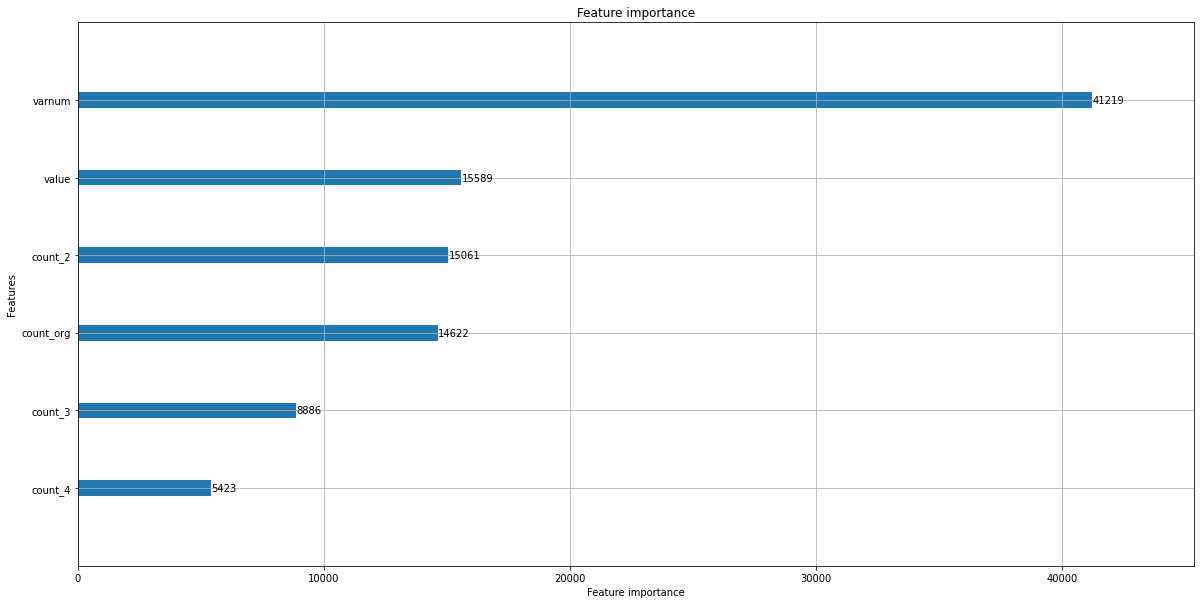

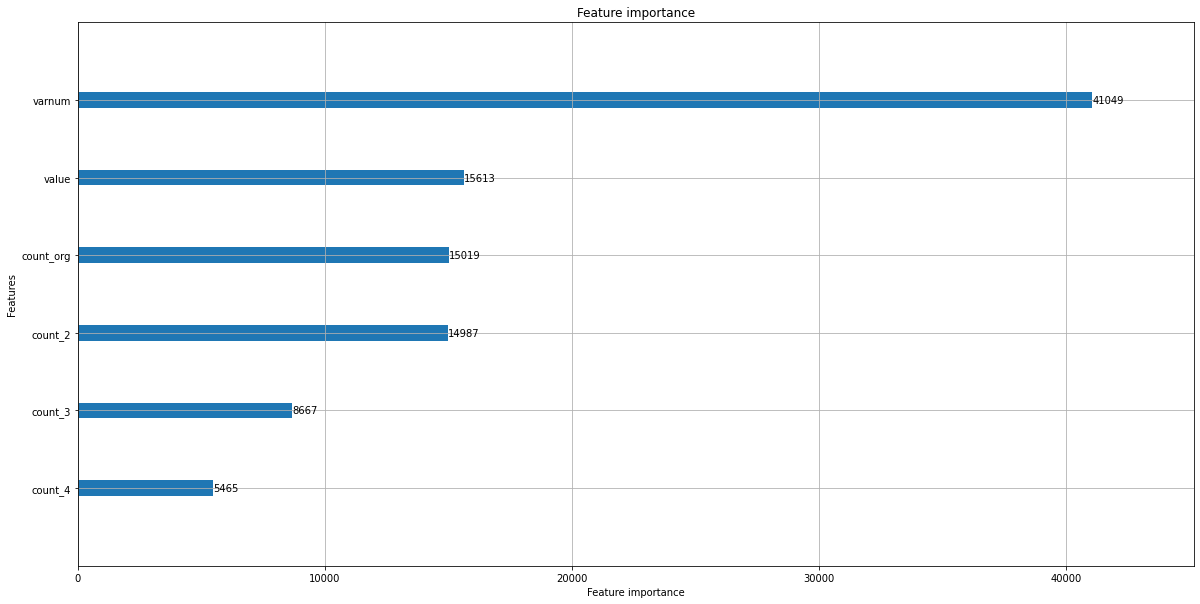

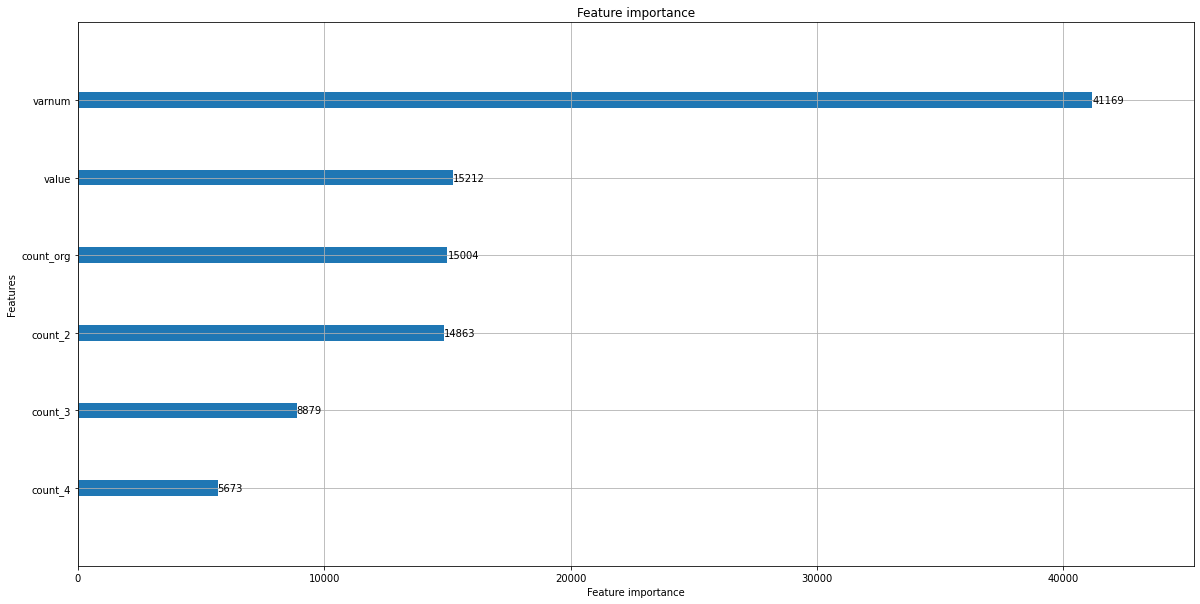

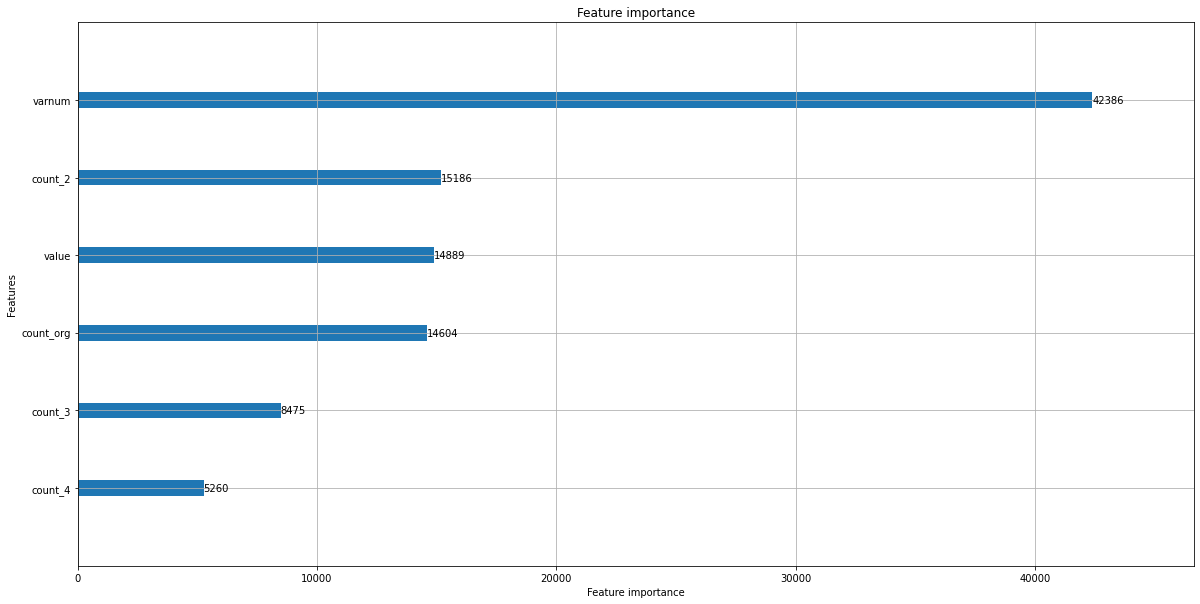

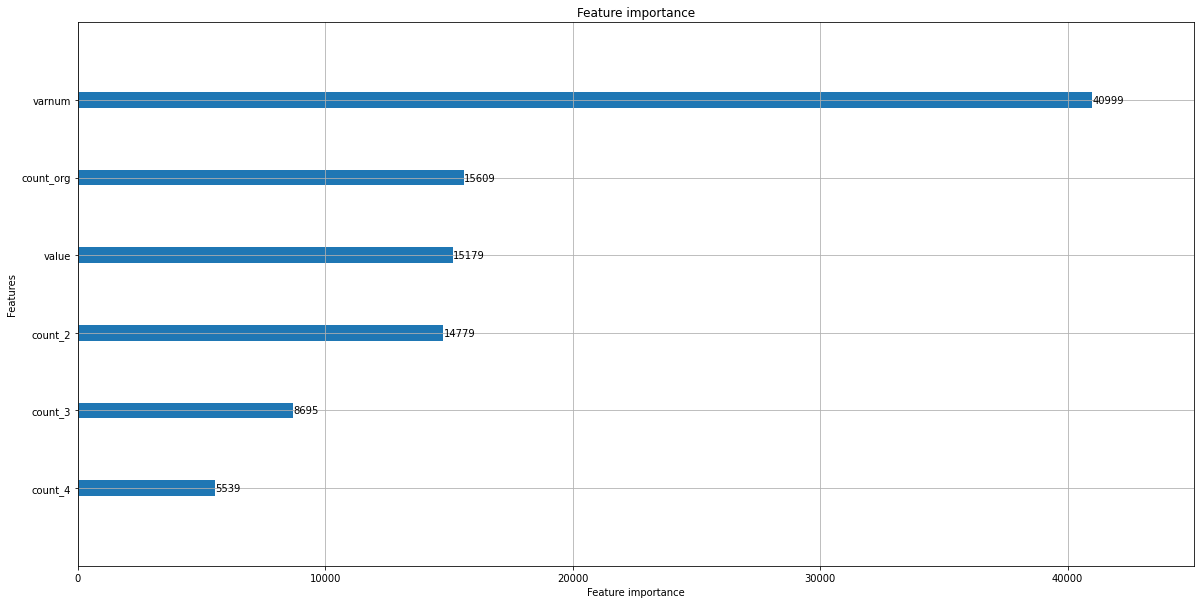

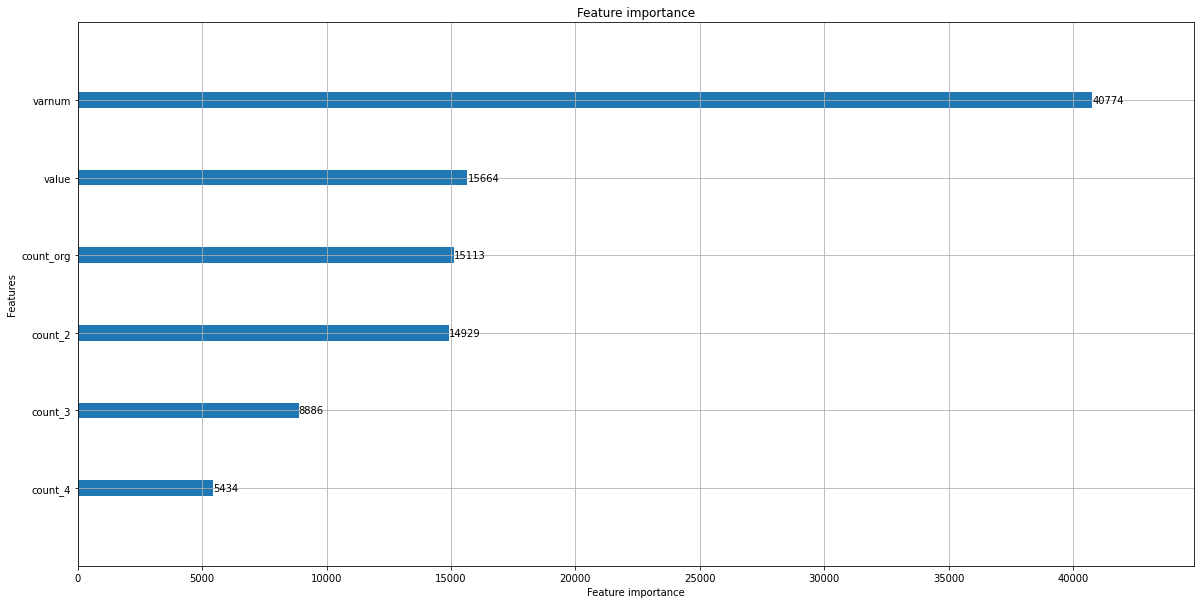

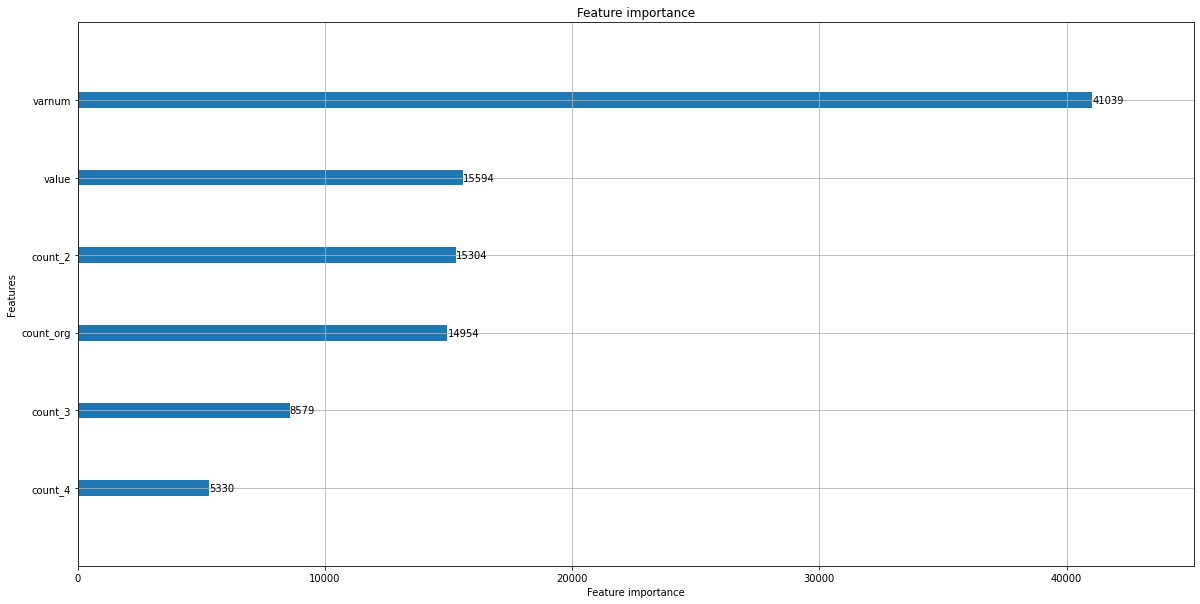

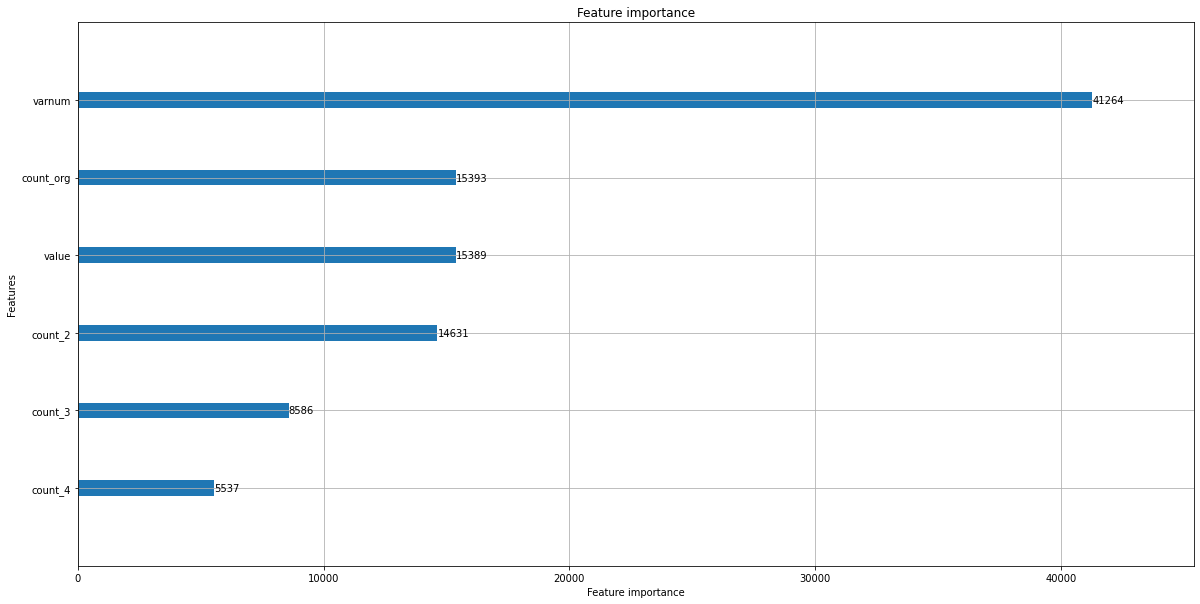

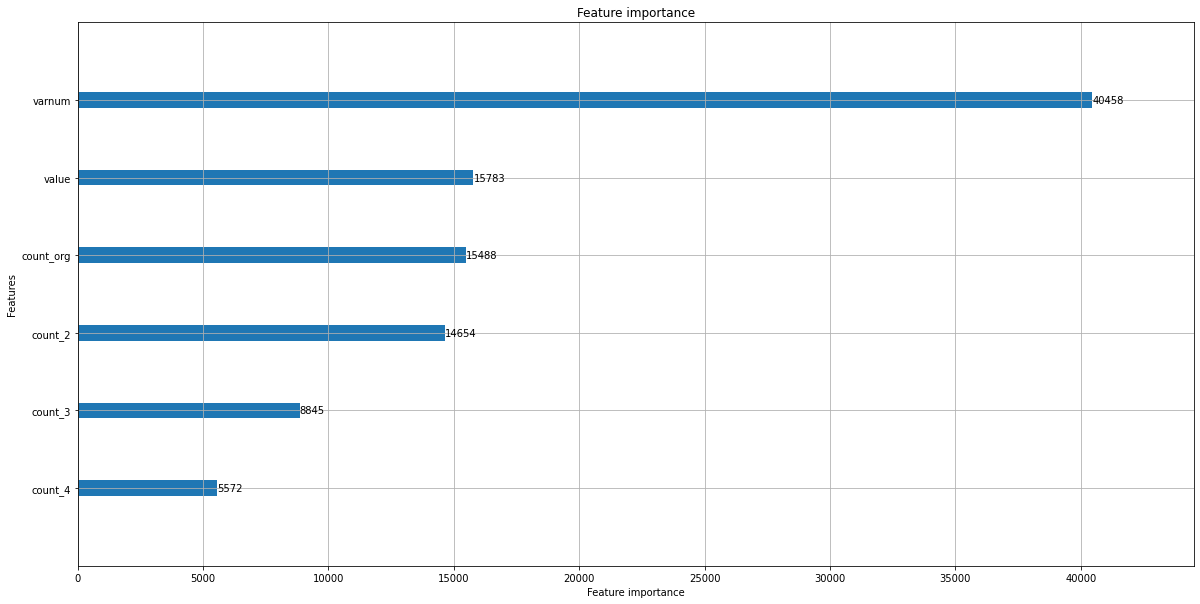

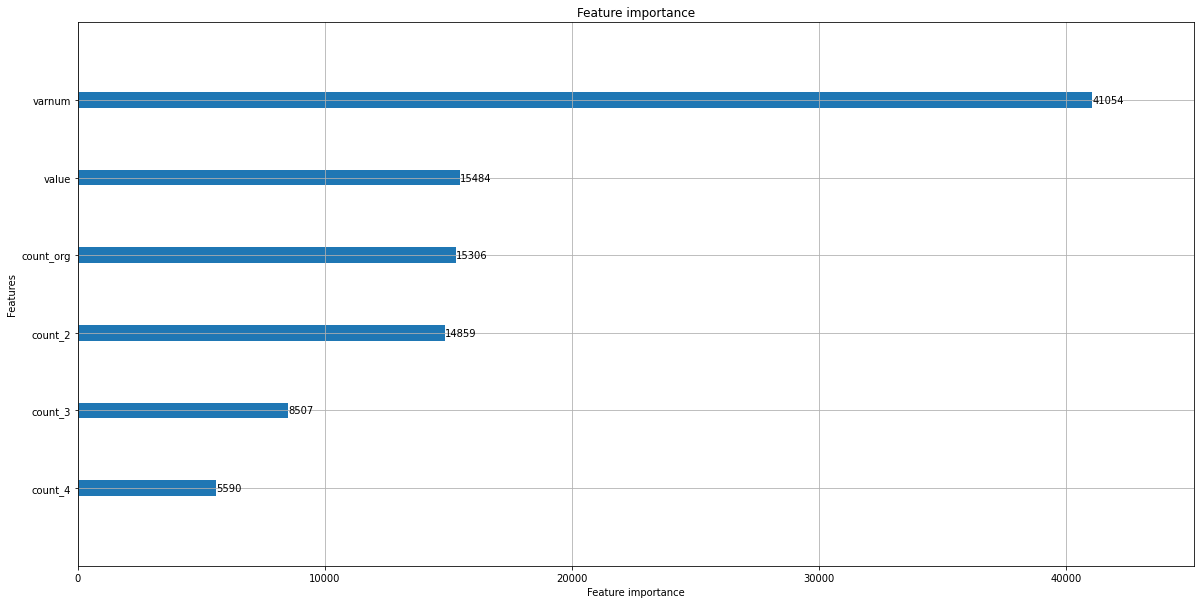

In [32]:
models = []
for i in range(10):
  print(i)
  file =OUT_PUT+'model'+ str(i)+'.txt'
  tree_img =OUT_PUT+'tree_model'+ str(i)+'.svg'
  model = lgb.Booster(model_file=file)
  tree = lgb.create_tree_digraph(model)
  with open(tree_img, 'w') as f:
    f.write(tree._repr_svg_())

  models.append(model)

  fig, ax = plt.subplots(figsize=(20, 10))
  lgb.plot_importance(model,ax=ax)
  feat_importance_img =OUT_PUT+'feat_importance_model'+ str(i)+'.svg'
  with open(feat_importance_img, 'w') as f:
    f.write(tree._repr_svg_())

  print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.show()

In [29]:
t = lgb.create_tree_digraph(models[9])
with open('fst.svg', 'w') as f:
    f.write(t._repr_svg_())